In [1]:
import re
from nltk import word_tokenize
from nltk.corpus import stopwords
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten,Dropout
import numpy as np
import gensim.downloader as api
import pandas as pd

In [2]:
wv = api.load('word2vec-google-news-300')
sw = stopwords.words('english')

In [3]:
def preprocess_text(sentence):
    sentence = sentence.lower()
    sentence = re.sub(r'[^\w\s]', '', sentence)
    words = word_tokenize(sentence)
    words = [word for word in words if word.isalpha()]
    words = [word for word in words if word not in sw]
    return words


def tokens_to_avg_vector(tokens, wv):
    vectors = []
    for token in tokens:
        if token in wv:
            vectors.append(wv[token])
    if len(vectors) == 0:
        return np.zeros(300)
    vectors = np.array(vectors)
    return np.mean(vectors, axis=0)

def apply_preprocessing_techniques(sentence):
    tokens = preprocess_text(sentence)
    vector = tokens_to_avg_vector(tokens,wv)
    vector = np.array(vector)
    return vector

In [4]:
df = pd.read_csv('spam.csv')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [5]:
df.drop(['Unnamed: 2','Unnamed: 3','Unnamed: 4'],axis='columns',inplace=True)
df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [6]:
df['v2'] = df['v2'].apply(apply_preprocessing_techniques)

In [7]:
df.head()

,v1,v2
0,ham,"[-0.019805908, 0.05167062, 0.02709961, 0.21868..."
1,ham,"[-0.06323496, 0.0803833, 0.060943604, 0.102498..."
2,spam,"[-0.0058455467, -0.025154114, -0.07952881, 0.0..."
3,ham,"[-0.06568061, 0.0262146, 0.1081543, 0.0869751,..."
4,ham,"[0.041534424, 0.02865982, 0.056930542, 0.16627..."


In [8]:
len(df)

5571

In [9]:
df['v1'].replace({'ham' : 0,'spam' : 1},inplace=True)
df.head()

,v1,v2
0,0,"[-0.019805908, 0.05167062, 0.02709961, 0.21868..."
1,0,"[-0.06323496, 0.0803833, 0.060943604, 0.102498..."
2,1,"[-0.0058455467, -0.025154114, -0.07952881, 0.0..."
3,0,"[-0.06568061, 0.0262146, 0.1081543, 0.0869751,..."
4,0,"[0.041534424, 0.02865982, 0.056930542, 0.16627..."


In [10]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix,r2_score

In [11]:
x = df['v2'].tolist()
x = np.array(x)
y = df['v1']

In [12]:
print(x.shape)
print(y.shape)

(5571, 300)
(5571,)


In [13]:
x_train,x_test,y_train,y_test = train_test_split(x,y,random_state=42,test_size=0.2)

In [14]:
x_train.shape,x_test.shape


((4456, 300), (1115, 300))

In [15]:
y_train.shape,y_test.shape

((4456,), (1115,))

In [16]:
x_train_reshaped = np.expand_dims(x_train, axis=1)
x_test_reshaped = np.expand_dims(x_test, axis=1)

In [17]:
x_train_reshaped.shape

(4456, 1, 300)

In [18]:
model = Sequential([
    Flatten(input_shape=((1,300))),
    Dense(256, activation='relu'),
    Dropout(0.4),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.1),
    Dense(2, activation='softmax'),
])

model.compile(
    optimizer= 'adam',
    metrics = ['accuracy'],
    loss = "sparse_categorical_crossentropy",
)

model.summary()

c:\Users\Hp\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 300)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        77,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 118,338 (462.26 KB)

 Trainable params: 118,338 (462.26 KB)

 Non-trainable params: 0 (0.00 B)

In [20]:
history = model.fit(x_train_reshaped,y_train,epochs =50)

Epoch 1/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9997 - loss: 0.0016
Epoch 2/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9992 - loss: 0.0018
Epoch 3/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9958 - loss: 0.0090
Epoch 4/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9989 - loss: 0.0051
Epoch 5/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9986 - loss: 0.0041
Epoch 6/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9991 - loss: 0.0038
Epoch 7/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9987 - loss: 0.0044
Epoch 8/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9970 - loss: 0.0114
Epoch 9/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9998 - loss: 0.0015
Epoch 10/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9995 - loss: 0.0017
Epoch 11/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9992 - loss: 0.0023
Epoch 12/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

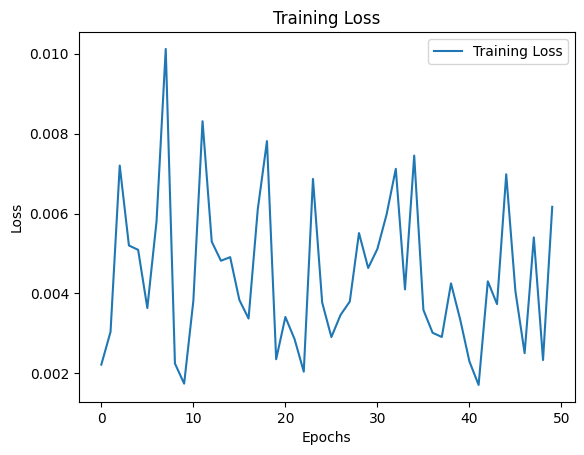

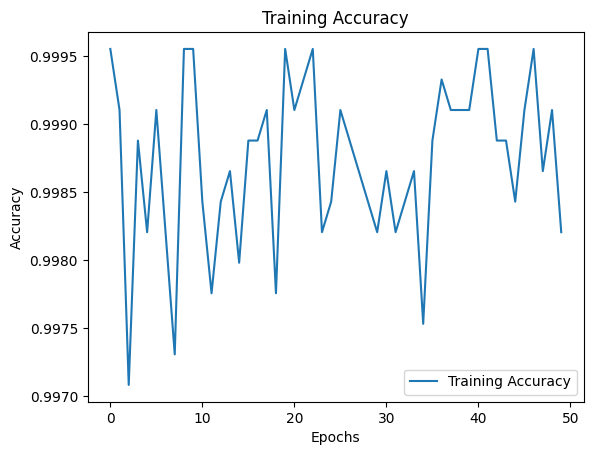

In [25]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve

# Plot Training and Validation Loss
plt.plot(history.history['loss'], label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()

# Plot Training and Validation Accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()
plt.show()



In [26]:
model.evaluate(x_test_reshaped,y_test)

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 765us/step - accuracy: 0.9762 - loss: 0.1814


[0.23035168647766113, 0.9730941653251648]

In [28]:
pred = model.predict(x_test_reshaped)

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [32]:
pred = [np.argmax(p) for p in pred]

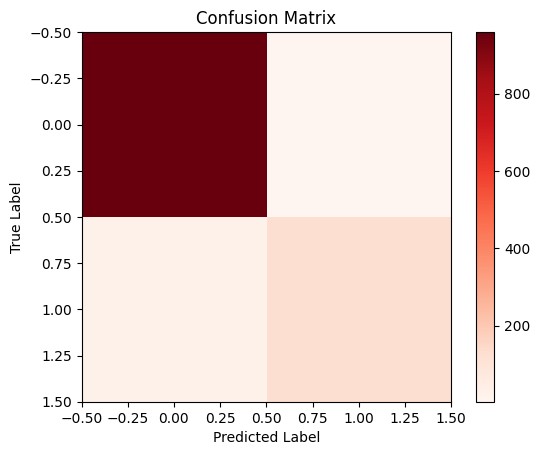

In [36]:
cm = confusion_matrix(y_test, pred)
plt.imshow(cm, cmap=plt.cm.Reds)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [22]:
x_test_reshaped

array([[[-0.0136556 ,  0.06039225,  0.05173747, ..., -0.04850057,
         -0.02947947,  0.08904622]],

       [[-0.05633109,  0.04280308,  0.00084359, ..., -0.15880585,
         -0.01007952,  0.05795506]],

       [[ 0.000875  , -0.0052948 , -0.02074242, ..., -0.0433197 ,
         -0.00087929,  0.01417923]],

       ...,

       [[-0.01041412, -0.00645447, -0.02990532, ..., -0.1328125 ,
         -0.11175537,  0.03038406]],

       [[-0.0750173 ,  0.06591797, -0.00518799, ..., -0.01511637,
          0.02776782,  0.01346588]],

       [[ 0.03892687,  0.0212538 ,  0.06591797, ..., -0.06355116,
          0.07945421,  0.01798503]]])

In [23]:
pred = [np.argmax(p) for p in pred]

In [24]:
pred

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [25]:
pred[:5]

[0, 0, 0, 0, 0]

In [26]:
y_test[:5]

1168    0
765     0
465     0
1117    0
4934    0
Name: v1, dtype: int64

In [27]:
messages = [
    "Hey, just wanted to see how you're doing. Everything going well?",
    "Are you free for dinner tonight? Let's catch up!",
    "Hope you're having a great day! Let's plan something fun for the weekend.",
    "Click here to claim your exclusive prize! Limited time offer!",
    "Congratulations! You've won a free vacation! Click now to claim your prize!",
    "URGENT: Your account needs verification. Click here to proceed."
]


In [28]:
m_p = []
for m in messages:
    vec = apply_preprocessing_techniques(m)
    vec = np.array([vec])
    vec = np.expand_dims(vec,axis=1)
    m_p.append(model.predict(vec))
    

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


In [29]:
m_p = [np.argmax(p) for p in m_p]

In [30]:
final_pred = []
for p in m_p:
    if p==0:
        final_pred.append('Ham')
    else:
        final_pred.append('Spam')
final_pred
        

['Ham', 'Ham', 'Ham', 'Spam', 'Spam', 'Ham']

In [31]:
model.save('CL_FD_MODEL_V2.keras')

In [32]:
from tensorflow.keras.models import load_model

In [33]:
CL_FD_MODEL_V1_MODEL = load_model('CL_FD_MODEL_V2.keras')

In [34]:
random_vec = apply_preprocessing_techniques('Hey bro i have been waiting for you outside your home since the past few minutes. Can you open it soon ? ')
random_vec =np.array([random_vec])

In [35]:
random_vec = random_vec.reshape(-1,1)

In [36]:
print(random_vec.shape)

(300, 1)


In [37]:
random_vec = np.expand_dims(random_vec,axis=0)

In [38]:
random_vec = random_vec.reshape(1,1,300)

In [39]:
random_vec.shape

(1, 1, 300)

In [40]:
pred = CL_FD_MODEL_V1_MODEL.predict(random_vec)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


In [41]:
pred = np.argmax(pred)
pred

0